# Usage Example

This is a guided walkthrough of the different functions provided by the `priceanalytics` (PA) library and examples of their usage.

## Analytic Pipeline

The "analytic pipeline" is the following sequence of steps. These provide the framework for creating models.

1. Pulling data
2. Designing model
3. Fitting/backtesting model

The point of PA is to provide functionality to handle commonly used operations.

## PriceAnalytics Packages

- **backtest**    package to test position logic for a model on historical data
- **data**        package to handle current marketdata and historical datasets 
- **plot**        package with plotting utilities
- **indicators**  package for commmonly used math/stat/analytic functions
- ***keys***    *internal package, used to handle API keys*


# Notebook Setup

There is some boilerplate code that should be added to the top of each notebook, and ran as the first operation in the kernal.

## Jupyter Reload Directives

The directives (the lines that start with `%`) tell Jupyter to notice and load any changes to imported Python files.

## Using `priceanalytics` from a model directory

If you are in a subdirectory of root (`.`) like we are in this directory, you must add `priceanalytics` to your module path using the `sys.path.append('.')` function call.

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

# Using the `data` Package

In [33]:
# Import package data
import priceanalytics.data as data

# Download data for a single stock from Alpaca as a df
df = data.alpaca_download_single(
    'AAPL',       # required arg, stock ticker
    past_days=30, # how many days back to grab
    interval=1    # interval between bars in minutes (ie. 1, 5, 15)
)

print(df)

                                    open    high       low     close  volume  \
symbol timestamp                                                               
AAPL   2023-11-16 11:05:00+00:00  188.26  188.26  188.2600  188.2600   586.0   
       2023-11-16 11:06:00+00:00  188.30  188.30  188.3000  188.3000   503.0   
       2023-11-16 11:11:00+00:00  188.13  188.13  188.1100  188.1100  1565.0   
       2023-11-16 11:12:00+00:00  188.13  188.13  188.1300  188.1300   700.0   
       2023-11-16 11:17:00+00:00  188.13  188.13  188.1300  188.1300   435.0   
...                                  ...     ...       ...       ...     ...   
       2023-12-16 00:55:00+00:00  196.68  196.71  196.6800  196.7100  1380.0   
       2023-12-16 00:56:00+00:00  196.71  196.75  196.7000  196.7200  3819.0   
       2023-12-16 00:57:00+00:00  196.70  196.70  196.6600  196.6600  1141.0   
       2023-12-16 00:58:00+00:00  196.68  196.68  196.6600  196.6600  1523.0   
       2023-12-16 00:59:00+00:00  196.66

In [35]:
# This function splits up a dataframe into a list of smaller dataframes,
# containing one trading day each
dfs = data.split_alpaca_on_day(df)

print(len(dfs))
print(dfs[-1])

20
                                     open      high       low    close  \
symbol timestamp                                                         
AAPL   2023-12-15 14:30:00+00:00  197.530  198.0100  197.3300  197.790   
       2023-12-15 14:31:00+00:00  197.780  197.9300  197.6300  197.850   
       2023-12-15 14:32:00+00:00  197.860  197.9268  197.4800  197.480   
       2023-12-15 14:33:00+00:00  197.500  197.5500  197.1250  197.190   
       2023-12-15 14:34:00+00:00  197.190  197.4700  197.1801  197.250   
...                                   ...       ...       ...      ...   
       2023-12-15 20:55:00+00:00  197.830  197.8400  197.6300  197.710   
       2023-12-15 20:56:00+00:00  197.700  197.7700  197.4800  197.740   
       2023-12-15 20:57:00+00:00  197.747  197.7500  197.4700  197.695   
       2023-12-15 20:58:00+00:00  197.695  197.8000  197.6400  197.730   
       2023-12-15 20:59:00+00:00  197.740  197.7500  197.0000  197.120   

                                  

# Using the `plot` package

Lets start visualizing our times series data by making charts.

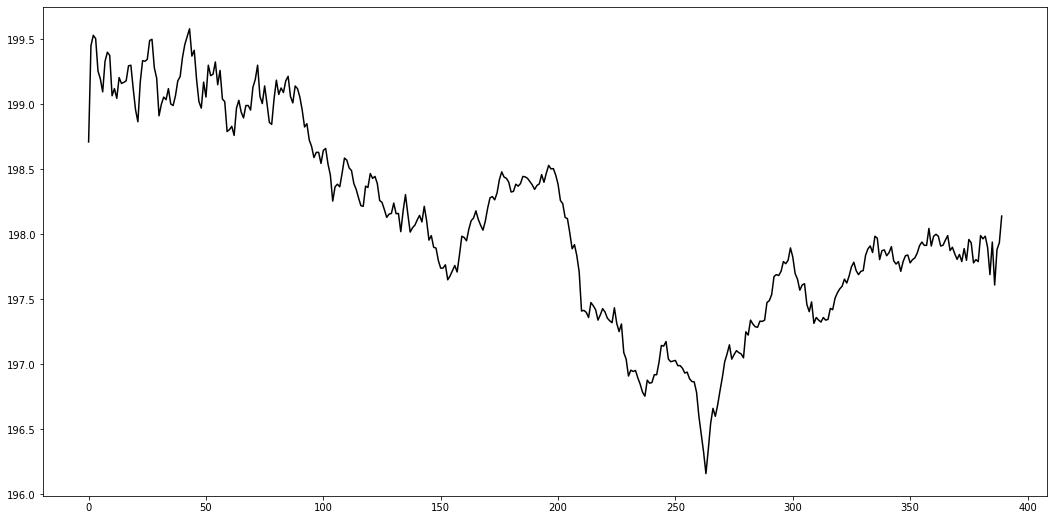

In [42]:
# Import the plot package
import priceanalytics.plot as plot

# Import matplotlib as well
import matplotlib.pyplot as plt

# To create a plot use the MultiPlot object
# Pass in a number of charts, followed by a size (x, y)
with plot.MultiPlot(1, size=(18, 9)) as m:
    # You can plot lines just like you would in matplotlib
    plt.plot(dfs[-2]['close'].to_numpy(), color='#000000')

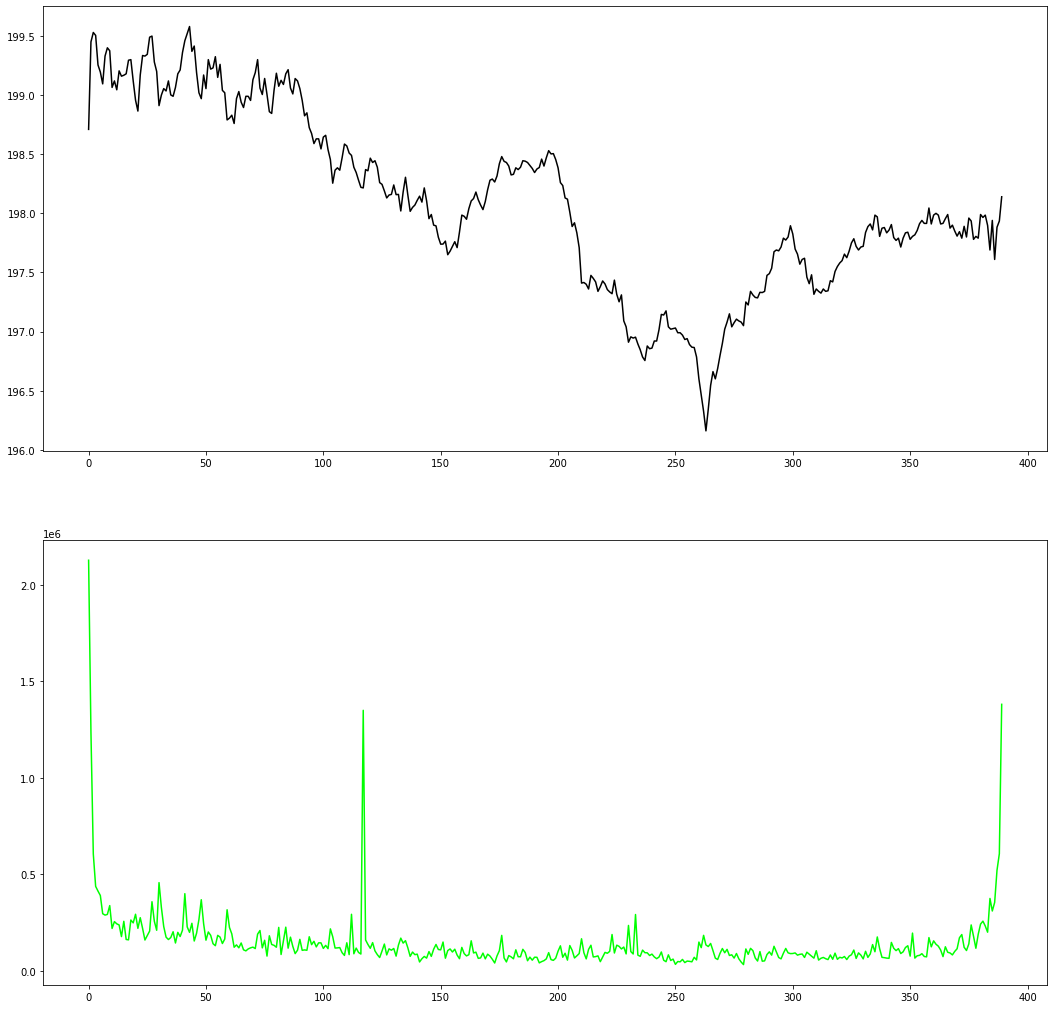

In [43]:
# Create multiple charts by changing the number of plots parameter
with plot.MultiPlot(2, size=(18, 18)) as m:
    # Plot first chart
    plt.plot(dfs[-2]['close'].to_numpy(), color='#000000')
    # When you want to plot something else, call below
    m.next()
    # And now plot as normal
    plt.plot(dfs[-2]['volume'].to_numpy(), color='#00FF00')

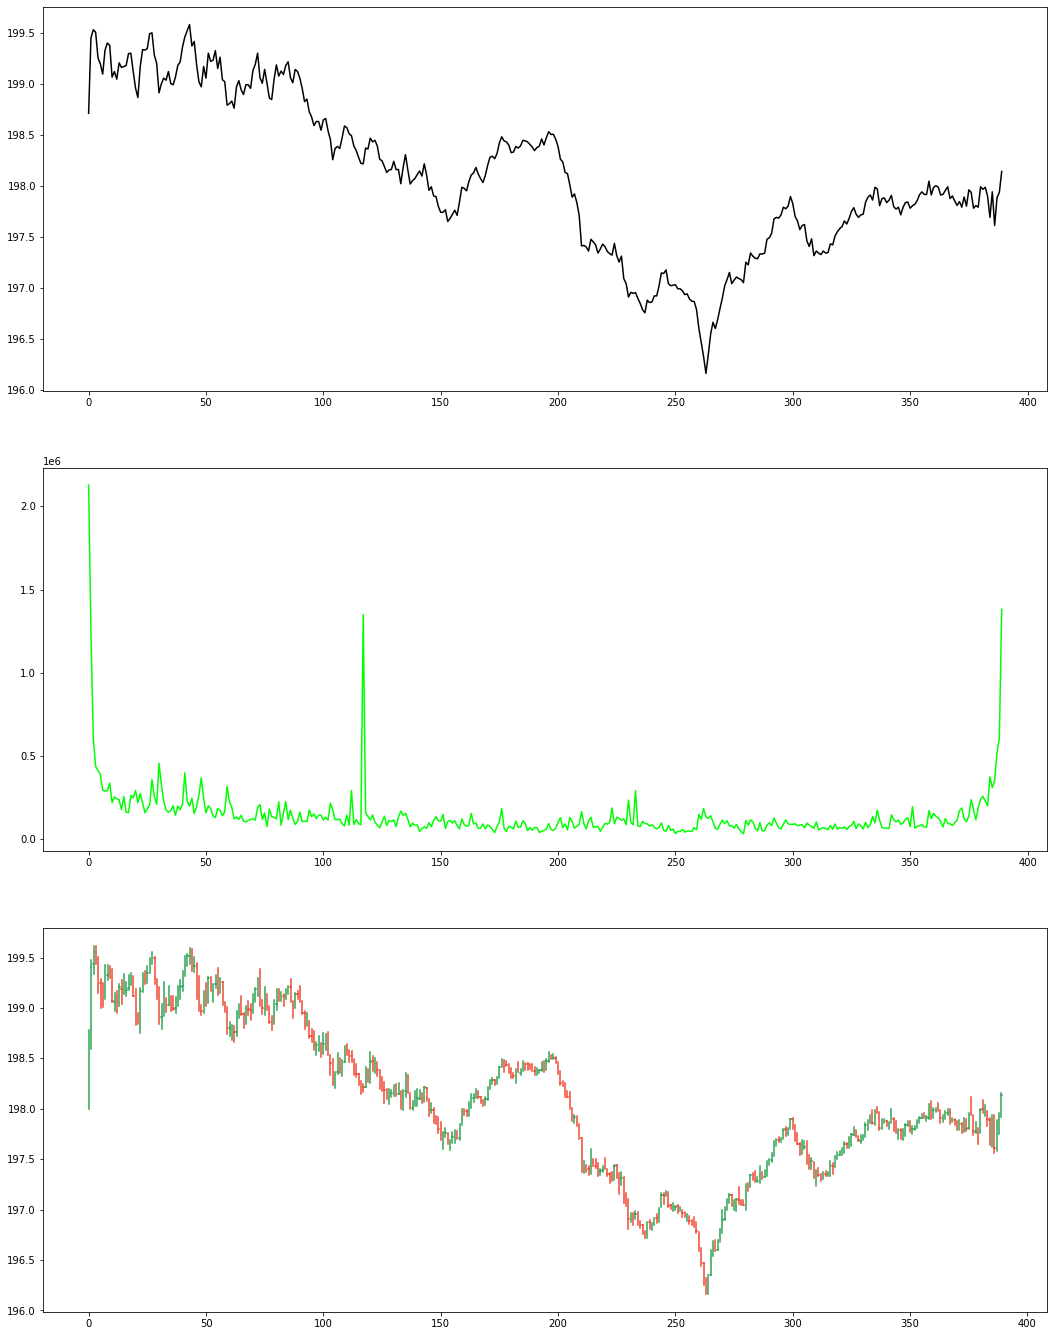

In [46]:
with plot.MultiPlot(3, size=(18, 24)) as m:
    plt.plot(dfs[-2]['close'].to_numpy(), color='#000000')
    m.next()
    plt.plot(dfs[-2]['volume'].to_numpy(), color='#00FF00')
    m.next()
    
    # The ohlc method can display candle sticks if you want that for some reason
    m.ohlc(dfs[-2])

# Using the `backtest` package

Implement trading logic and test returns on historical data.

In [54]:
# Import the backtester package
import priceanalytics.backtest as bt
    
# We are going to create a function that we can call later
def test_strategy(df):
    
    # Create a backtester
    with bt.Backtester(df) as b:
        # This loop runs for row in the dataframe, this simulates
        # every update in production, each with one more row of data
        # - i   is the loop count, range [0, len(df))
        # - fr  is the past slice of data, all the datapoints from df ranged [0, i]
        for i, fr in b:
            
            # Every loop you must run any calculations necessary for the logic
            # For this example strategy it is caculating a moving average
            
            price = fr['close'].to_numpy()
            moving_avg = fr['close'].rolling(10).mean().to_numpy()
            
            # Specify any requirements for length like so
            if len(price) <= 6: continue
            
            # Now you implement the logic like so, the following logic 
            # will buy when price crosses above moving_avg and sell when
            # price crosses below moving_avg
            
            if price[-1] > moving_avg[-1] and price[-2] < moving_avg[-2]:
               
                # b.buy() is the function to enter long
                b.buy()
            
            if price[-1] < moving_avg[-1] and price[-2] > moving_avg[-2]:
                
                # b.sell() is the function to enter short
                b.sell()
            
        return b.results(1)

r = test_strategy(dfs[-2])
print(r)

0.003673996298988458
